# Imports
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5042C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">

</p>
</div>

In [1]:
# Setup feedback system
import pandas as pd 
import os
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from xgboost import  XGBRegressor

# Loading datasets
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5042C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">

</p>
</div>

In [2]:
## Path of datasets
path='../input/store-sales-time-series-forecasting/'

## Train & Test Datasets
train=pd.read_csv(path+'train.csv',parse_dates=['date'])
test=pd.read_csv(path+'test.csv',parse_dates=['date'])

## Supplementary Datasets
oil=pd.read_csv(path+'oil.csv',parse_dates=['date'])
holidays_events=pd.read_csv(path+'holidays_events.csv',parse_dates=['date'])
stores=pd.read_csv(path+'stores.csv')
transactions=pd.read_csv(path+'transactions.csv',parse_dates=['date'])


In [3]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [4]:
average_sales

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 227, dtype: float32

-------------------------------------------------------------------------------

Examine the following seasonal plot:

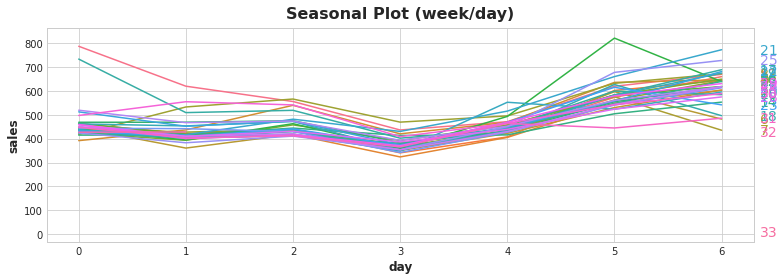

In [5]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

And also the periodogram:

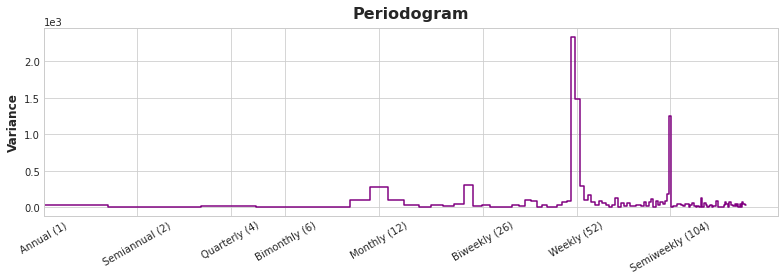

In [6]:
plot_periodogram(average_sales);

# Features Engineering & Model 
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5042C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">

</p>
</div>

### Preparing data

In [7]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='W', order=12)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)


model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [8]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

### TRAINSET

In [9]:
## fixing date keyerror 
X['date'] =  X.index
X.reset_index(drop= True, inplace= True)


In [10]:
## Merging and Mapping:
holidays_events=pd.read_csv(path+'holidays_events.csv',parse_dates=['date'])

holidays_events=holidays_events[['date','type']] ## Keep date & holiday type for merging
X=pd.merge(left=X, right=holidays_events, on='date', how='left')

X.rename({'type':'is_holiday'},axis=1,inplace=True)
X['is_holiday']=X.is_holiday.map({'Holiday':1,'Additional':1,'Event':1,
                                                  'Bridge':1,'Transfer':1}).fillna(0).astype('int8')

## Adding weekends to holiday as well
X.set_index('date',inplace=True)
X['day_of_week']=X.index.dayofweek.astype('int8')
X.loc[(X['day_of_week']==5) | (X['day_of_week']==6), 'is_holiday']=1

## Removing he first day of a year from holidays as mentioned before Favorita is closed these days.
X['day_of_year']=X.index.dayofyear.astype('int16')
X.loc[X['day_of_year']==1 ,'is_holiday']=0


X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",NewYear,is_holiday,day_of_week,day_of_year
date,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0,6,1
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,False,0,0,2
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,False,0,1,3
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,False,0,2,4
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,False,0,3,5


In [11]:
X['date']=X.index
X['date']=X['date'].astype(str)
X['date']=pd.to_datetime(X['date'])

In [12]:
X.reset_index(drop=True, inplace=True)
oil.reset_index(drop=True, inplace=True)

In [13]:
## create onpromotion feature 
onpromtionTrain = train.groupby(['date']).mean().loc["2017"]['onpromotion']
onpromtionTrain = pd.DataFrame(onpromtionTrain)
onpromtionTrain['date'] = onpromtionTrain.index
onpromtionTrain.reset_index(drop=True, inplace=True)

In [14]:
X=pd.merge(left=X,right=oil,on='date',how='left')
X.rename({'dcoilwtico':'oil_price'},axis=1,inplace=True)
X['oil_price']=X['oil_price'].fillna(0)


In [15]:
X=pd.merge(left=X, right=onpromtionTrain, on='date', how='left')

In [16]:
## drop X row with NAN
X.dropna(inplace=True)
y = y.iloc[X.index]

### TESTSET

In [17]:
## Merging and Mapping:
holidays_events=holidays_events[['date','type']] ## Keep date & holiday type for merging
X_test=pd.merge(left=X_test, right=holidays_events, on='date', how='left')
X_test.rename({'type':'is_holiday'},axis=1,inplace=True)
X_test['is_holiday']=X_test.is_holiday.map({'Holiday':1,'Additional':1,'Event':1,
                                                  'Bridge':1,'Transfer':1}).fillna(0).astype('int8')

## Adding weekends to holiday as well
X_test.set_index('date',inplace=True)
X_test['day_of_week']=X_test.index.dayofweek.astype('int8')
X_test.loc[(X_test['day_of_week']==5) | (X_test['day_of_week']==6), 'is_holiday']=1

## Removing he first day of a year from holidays as mentioned before Favorita is closed these days.
X_test['day_of_year']=X_test.index.dayofyear.astype('int16')
X_test.loc[X_test['day_of_year']==1 ,'is_holiday']=0

X_test.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",NewYear,is_holiday,day_of_week,day_of_year
date,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,False,0,2,228
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,False,0,3,229
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,False,0,4,230
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,False,1,5,231
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,False,1,6,232


In [18]:
X_test['date']=X_test.index
X_test['date']=X_test['date'].astype(str)
X_test['date']=pd.to_datetime(X_test['date'])

In [19]:
X_test=pd.merge(left=X_test,right=oil,left_index=True,right_index=True,how='left')
X_test.rename({'dcoilwtico':'oil_price'},axis=1,inplace=True)
X_test['oil_price']=X_test['oil_price'].fillna(0)

In [20]:
X_test.drop(columns=['date_y','date_x'], inplace=True)
X.drop(columns='date', inplace=True)

In [21]:
X_test['date'] = X_test.index
X_test.reset_index(drop=True, inplace=True)

In [22]:
## create onpromotion feature 
onpromtionTest = df_test.groupby(['date']).mean().loc["2017"]['onpromotion']
onpromtionTest = pd.DataFrame(onpromtionTest)
onpromtionTest['date'] = onpromtionTest.index
onpromtionTest.reset_index(drop=True, inplace=True)

In [23]:
X_test=pd.merge(left=X_test, right=onpromtionTest, on='date', how='left')

In [24]:
X_test.drop(columns=['date'], inplace=True)

In [25]:
#X.drop(columns=['date'], inplace=True)

In [26]:
# A parameter grid for XGBoost
params = {
    'learning_rate':[0.001,0.1,0.3,0.5,1],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,7]
        }

In [27]:
model = XGBRegressor(n_estimators=10, nthread=1)

In [28]:
folds = 3  
param_comb = 5 
#skf = kfolds(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(model, param_distributions=params, scoring='neg_mean_absolute_error', n_jobs=4, cv=3, verbose=3,  )

# Here we go
#start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
#timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          n_estimators=10, n_jobs=None,
                                  

In [29]:
random_search.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          n_estimators=10, n_jobs=None,
                                  

In [30]:
y_test = random_search.predict(X_test)

In [31]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 All results:
{'mean_fit_time': array([7.00930826, 3.1225365 , 4.19639277, 3.38198161, 4.05677263,
       3.72234933, 4.82631453, 3.94921597, 4.17776656, 3.9014891 ]), 'std_fit_time': array([0.07749651, 0.04421112, 0.02589753, 0.08659266, 0.13529317,
       0.0243102 , 0.05220339, 0.02208092, 0.00747854, 0.09342804]), 'mean_score_time': array([0.09803891, 0.05274566, 0.0588096 , 0.05970343, 0.05719336,
       0.05120039, 0.07316065, 0.05137897, 0.05456265, 0.04705548]), 'std_score_time': array([0.00317044, 0.00211585, 0.00230637, 0.00569077, 0.004601  ,
       0.00174933, 0.00886145, 0.00269559, 0.00412812, 0.00176083]), 'param_subsample': masked_array(data=[0.6, 0.8, 1.0, 1.0, 0.6, 1.0, 1.0, 0.6, 1.0, 0.8],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 10, 10, 5, 10, 5, 10, 10, 10, 1],
             mask=[False, False, False, 

In [32]:
y_test = y_test.reshape(28512,1)

In [33]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['sales']= y_test
submission.to_csv("submission.csv", index=False)

In [34]:
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv